<a href="https://colab.research.google.com/github/nachovera93/IA-Documents/blob/main/Practico_3_Diplomado_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomado IA

## Inteligencia Artificial I - Herramientas 2

Profesores:

*   Felipe del Río
*   Julio Hurtado

Ayudante:

* Andres Carvallo 


## Agenda


1.   Actividad 1 - Gradient Descend
 - Función Lineal
 - Función Cuadrática
2.   Actividad 2 - Stochastic Gradient Descend
 - Modelo
 - **Actividad Práctica 1**
 - Ajuste de Hiperparámetros
 - **Actividad Práctica 2**
4.   Actividad 3 - Métodos de Gradiente Adaptativo
 - **Actividad Práctica 3**
6.   Actividad 4 - Schedulers


# Actividad 1 - Gradient Descent
 
Como vimos en clases, los modelos aprenden a partir de los datos en los cuales son entrenados. La forma que aprenden es tomando pequeños pasos en la dirección contraria al gradiente de la función de pérdida que estamos optimizando.
 
Para partir este laboratorio, definiremos dos funciones sencillas que nos permitirán analizar cómo evolucionan distintos modelos que vamos a proponer durante el proceso de entrenamiento.
 
La primera ecuación es lineal de la forma:
 
> $Y = 4 + 3 \cdot x$
 
La segunda es una ecuación un poco más compleja de aprender ya que consiste en una ecuación cuadrática de la forma:
 
> $Y = 4 + 3 \cdot x - 2 \cdot x^2$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""
Estas funciones son las encargadas de entregarnos el valor real (o con un pequeño ruido) cuando les entregamos un valor X
"""

def getTargetCuadratic(x, noise=False):
    y = 4 + 3 * x - 2 * x**2
    if noise:
        return y + np.random.randn(y.size)*0.5
    return y

def getTargetLinear(x, noise=False):
    y = 4 + 3 * x
    if noise:
        return y + np.random.randn(y.size)
    return y

## Gráficos de las ecuación
A continuación podemos ver cual es el comportamiento visual de las diferentes ecuaciones que implementamos anteriormente.

Al setear el parámetro de ruido como `False` en las funciones que nos entregan los datos, vemos que las curvas se adaptan perfectamente a la ecuación que queremos. Pero como sabes o vamos a descubrir, los datos en un entorno real, rara vez se adaptan perfectamente a la ecuación establecida. Por esto, le agregamos ruido a la salida de nuestras funciones para acercarnos a lo que puede ser la realidad.

Después de cada gráfico con los datos perfectos, graficamos la misma función pero agregando ruido gaussiano. Para esto, lo único que necesitamos es setear el hiper-parámetro `noise` de cada función cómo `True`.

Text(0, 0.5, 'y')

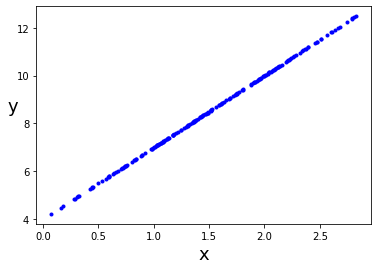

In [ ]:
x = np.linspace(0.0, 2.0, num=200) + np.random.rand(200)
plt.plot(x, getTargetLinear(x, False), 'b.')
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)

Text(0, 0.5, 'y')

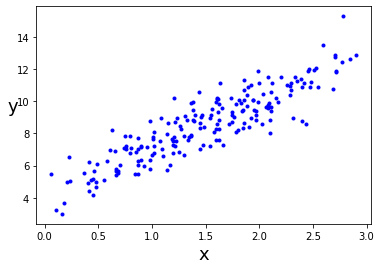

In [ ]:
x = np.linspace(0.0, 2.0, num=200) + np.random.rand(200)
plt.plot(x, getTargetLinear(x, True), 'b.')
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)

Text(0, 0.5, 'y')

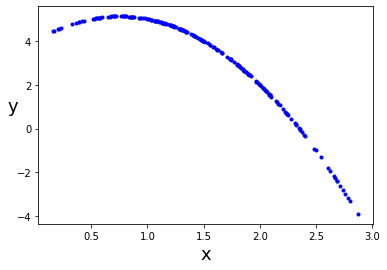

In [ ]:
x = np.linspace(0.0, 2.0, num=200) + np.random.rand(200)
plt.plot(x, getTargetCuadratic(x, False), 'b.')
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)

Text(0, 0.5, 'y')

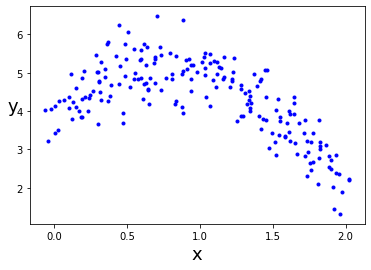

In [ ]:
x = np.linspace(0.0, 2.0, num=200) + np.random.uniform(low=-0.1, high=0.1, size=(200,))
plt.plot(x, getTargetCuadratic(x, True), 'b.')
plt.xlabel("x", fontsize=18)
plt.ylabel("y", rotation=0, fontsize=18)

## Gradient Descent

Una de las preguntas que aparecen al momento de entrenar estos modelos es poder definir hacia dónde nos conviene mover nuestros pesos para que el modelo vaya aproximandose a una mejor solución. Tal como vimos en clases, la dirección en la cual nos queremos mover es aquella que minimice la función de pérdida que definimos, y para eso es necesario moverse en sentido contrario a la pendiente del modelo en ese punto, o como también se conoce en el sentido contrario al gradiente.

## Ecuación que queremos aproximar

Primero necesitamos conocer las ecuaciones que queremos aproximar. Como estamos trabajando con funciones simples y queremos ver el impacto que tiene la actualización de los parámetros del modelo, definimos las dos funciones mostradas anteriormente. Con estas ecuaciones podemos definir dos modelos sencillos que nos ayudarán a aproximarlas utilizando solo los datos de entrenamiento.

Para el caso de la ecuación lineal definimos nuestro modelo como:

> $Y = 4 + 3 \cdot x$ \
> $\hat{Y} = h(\theta,x) = \theta_0 + \theta_1 \cdot x$

Para el caso de nuestra función cuadrática definimos nuestro modelo como:

> $Y = 4 + 3 \cdot x -2 \cdot x^2$ \
> $\hat{Y} = h(\theta,x) = \theta_0 + \theta_1 \cdot x + \theta_2 \cdot x^2$

Donde los valores $\theta_i$ son los parámetros que queremos aprender. Esto quiere decir, que estos son los valores que vamos a ir modificando en cada iteración del algoritmo para acercarnos a una buena aproximación de la función real.

## Función de pérdida

Lo segundo que necesitamos es una función de pérdida. Al ser un problema de regresión, debemos utilizar una función de pérdida que nos entregue la diferencia entre el valor esperado $Y$ y la predicción $\hat{Y}$. En esta oportunidad vamos a utilizar la función: *Mean Squared Error*, que tal como dice su nombre, calcula el error como la diferencia entre la predicción y el valor real, al cuadrado.

> $L(\theta) = \frac{1}{2m} \sum_{i=1}^m (h(\theta,x_i) - y_i)^2$

La función anterior, a pesar de ser muy simple, es muy utilizada en problemas de regresión, ya que nos dice claramente que tan lejos estamos de la solución real.

 



In [ ]:
def  cal_loss(theta, X, y):
    '''
    Esta función es la encargada de calcular el costo de las predicciones hechas por la 
    función con parametros theta
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions - y))
    return cost

## Gradiente

Lo único que nos falta es saber como calcular la dirección en la que tenemos que mover los pesos de nuestro modelo dado el error que nuestra función de pérdida nos entrega. Para esto, debemos derivar nuestra función de pérdida con respecto a cada parámetro que tenemos, resultando:

> $\frac{\partial L(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h(\theta,x_i) - y_i)\cdot X_i^j$

Dado lo anterior, la actualización de cada valor de $\theta$ de nuestro modelo quedaría de la siguiente forma:

> $\theta_j = \theta_j - \alpha \cdot \frac{1}{m} \sum_{i=1}^m (h(\theta,x_i) - y_i)\cdot X_i^j$,

ya que queremos movernos en sentido contrario al gradiente, multiplicado por $\alpha$ que es el valor de nuestro *learning rate*. Donde $j$ es el número de características de nuestras observaciones $X$.

In [ ]:
def gradient_descent(X, y, theta, learning_rate=0.01, iterations=100):
    '''
    X             = Observaciones
    y             = Valores reales de cada observación
    theta         = Parámetros de nuestro modelo
    learning_rate = Tasa de aprendizaje
    iterations    = número de iteraciones
    
    Se retorna el valor final de los parámetros y el historial de la función de costo
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,theta.size))
    for it in range(iterations):
        prediction = np.dot(X, theta)
        theta = theta - learning_rate * (1/m) * (X.T.dot((prediction - y)))

        theta_history[it,:] = theta.T
        cost_history[it]  = cal_loss(theta, X, y)
        
    return theta, cost_history, theta_history

## Métricas
Si tenemos un modelo que se demora días o semanas en entrenar, nos gustaría saber como va el entrenamiento antes de que terminara, principalmente para poder detectar problemas de manera más rápida, sin tener que esperar todo el proceso de entrenamiento.
 
Debido a lo anterior, es muy importante ir midiendo como evoluciona el valor de nuestra función de pérdida durante el entrenamiento, ya que es el valor que nos indica si efectivamente el modelo está entrenando o no. Durante el entrenamiento, esperamos que el valor de nuestra función de pérdida (calculado sobre los mismos datos de entrenamiento) baje, si esta no baja constantemente puede existir un problema.
 
Diferentes posibles problemas:
 
1.  El valor nunca baja: El modelo tiene un problema grave, ya que no se está actualizando correctamente los pesos.
2.  El valor baja pero hasta un valor alto o sube: Puede que el *learning rate* esté muy alto.
3.  El valor baja muy lento: Puede que el *learning rate* está muy bajo.
 
 
La siguiente función nos ayuda a visualizar como va el entrenamiento, graficando cómo evoluciona la función que queremos aproximar en comparación con la función real. Esto se puede hacer únicamente porque queremos aproximar funciones simples con baja dimensionalidad. En caso de modelos más complejos basta con ir analizando como evoluciona el valor de la función de pérdida en cada época.



In [ ]:
def plot_GD(x, y, theta_size, X_b, n_iter, lr, ax, ax1=None):
     """
     n_iter = no of iterations
     lr = Learning Rate
     ax = Axis to plot the Gradient Descent
     ax1 = Axis to plot cost_history vs Iterations plot

     """
     _ = ax.plot(x,y,'b.')
     theta = np.random.randn(theta_size, 1)

     tr = 0.1
     cost_history = np.zeros(n_iter)
     for i in range(n_iter):
        pred_prev = X_b.dot(theta)
        theta, h, _ = gradient_descent(X_b, y, theta, lr, 1)
        pred = X_b.dot(theta)

        cost_history[i] = h[0]

        if ((i % 25 == 0)):
            _ = ax.plot(x, pred, 'r-', alpha=tr)
            if tr < 0.8:
                tr = tr + 0.2
     if not ax1 == None:
        _ = ax1.plot(range(n_iter), cost_history, 'b.')

## Función Lineal



Theta0:	3.752,
Theta1:	3.219
Final cost/MSE:  1359.168


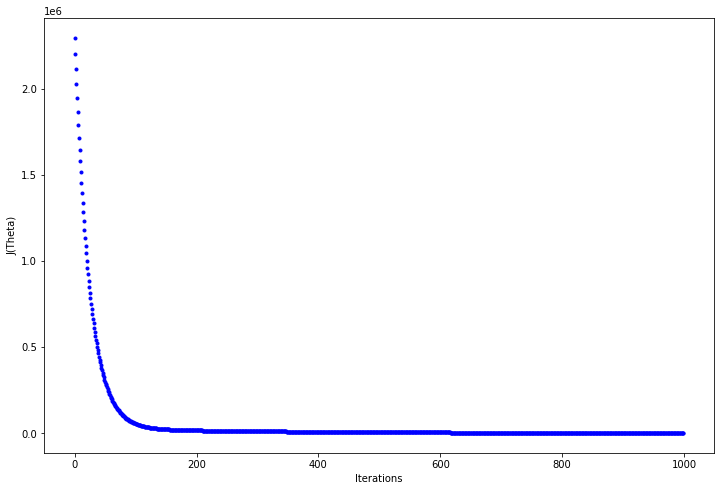

In [ ]:
# Primero debemos generar los datos que vamos a utilizar para entrenar nuestro modelo
x = np.random.uniform(low=0, high=2.0, size=(400,1))
y = getTargetLinear(x, False)

# Hiper-parámetros
lr = 0.01
n_iter = 1000

# En el caso lineal, nuestro modelo tiene solo 2 parámetros theta
theta = np.random.randn(2,1)
theta_size = 2

# Actualizamos las características de nuestro X
X_b = np.c_[np.ones((len(x), 1)), x]
theta, cost_history, theta_history = gradient_descent(X_b, y, theta, lr, n_iter)

print('Theta0:\t{:0.3f},\nTheta1:\t{:0.3f}'.format(theta[0][0], theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterations')
_ = ax.plot(range(n_iter), cost_history, 'b.')

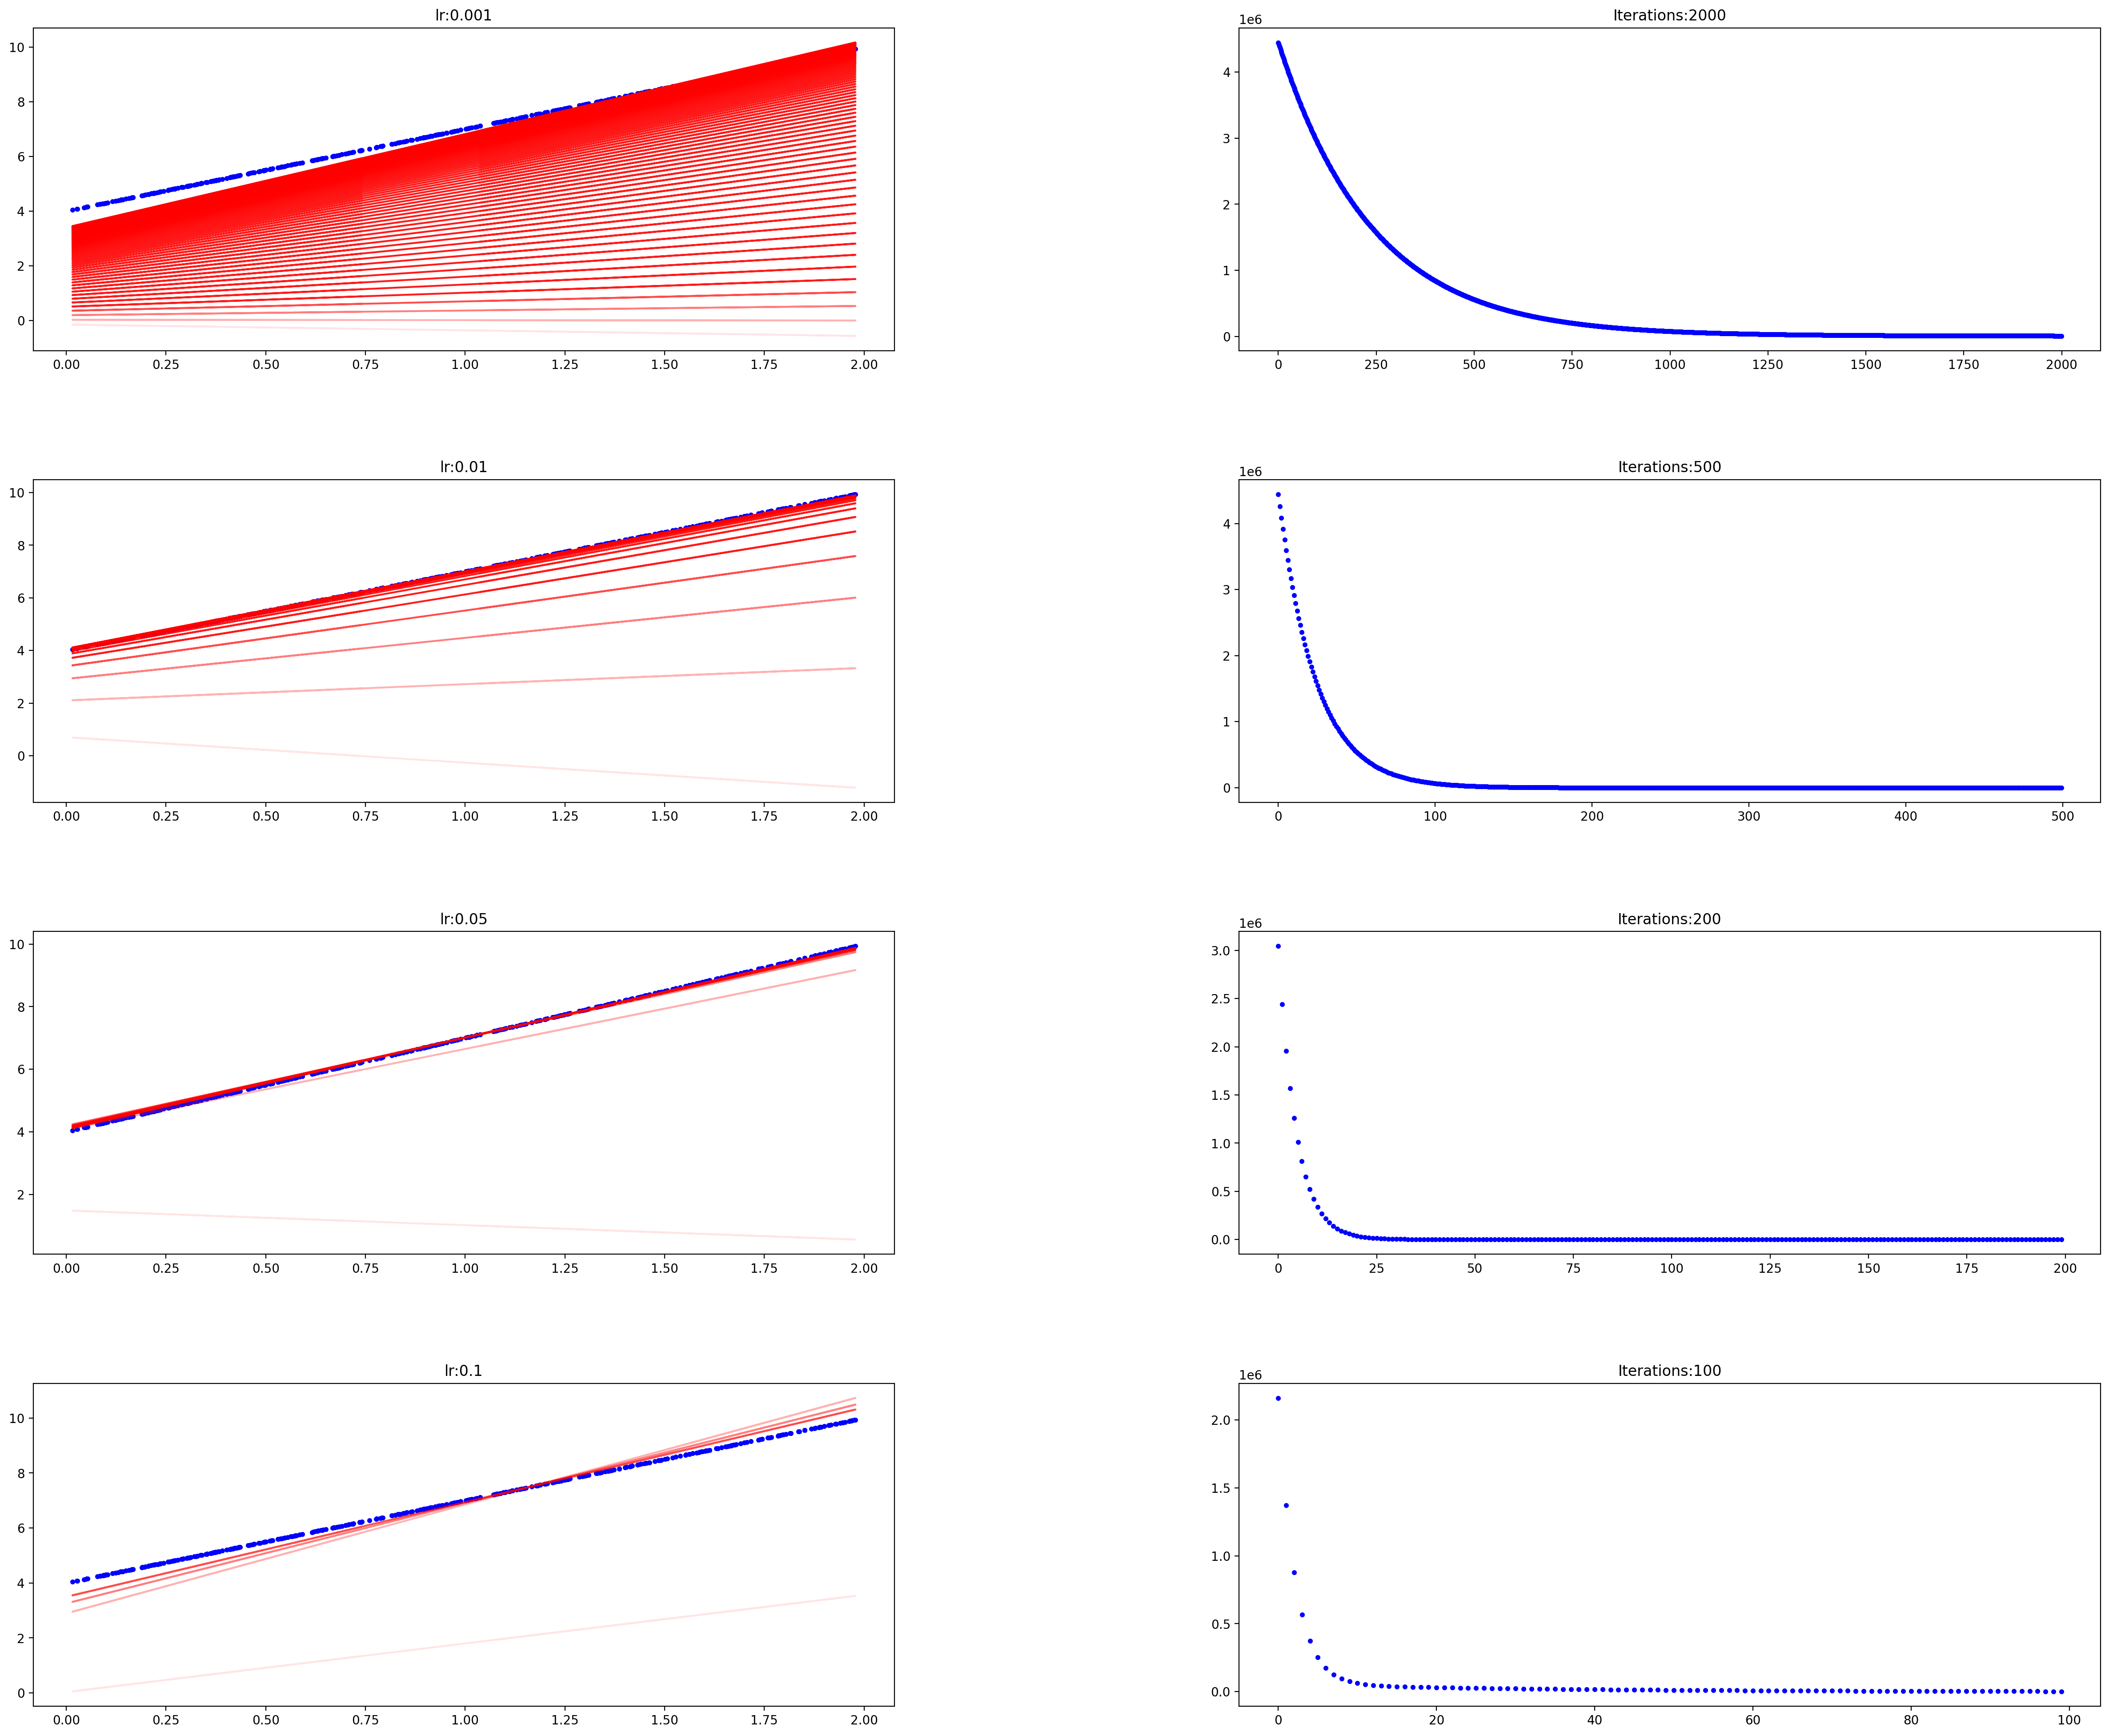

In [ ]:
fig = plt.figure(figsize=(30, 25), dpi=200)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

it_lr = [(2000, 0.001), (500, 0.01), (200, 0.05), (100, 0.1)]
count = 0
# Se gráfica cada combinación de número de iteraciones con el learning rate correspondiente
for n_iter, lr in it_lr:
    count += 1
    
    ax = fig.add_subplot(4, 2, count)
    count += 1
   
    ax1 = fig.add_subplot(4, 2, count)
    
    ax.set_title("lr:{}".format(lr))
    ax1.set_title("Iterations:{}".format(n_iter))
    plot_GD(x, y, theta_size, X_b, n_iter, lr, ax, ax1)

## Función Cuadrática

Theta0:	4.768,
Theta1:	0.881
Theta2:	-0.993
Final cost/MSE:  7157.466


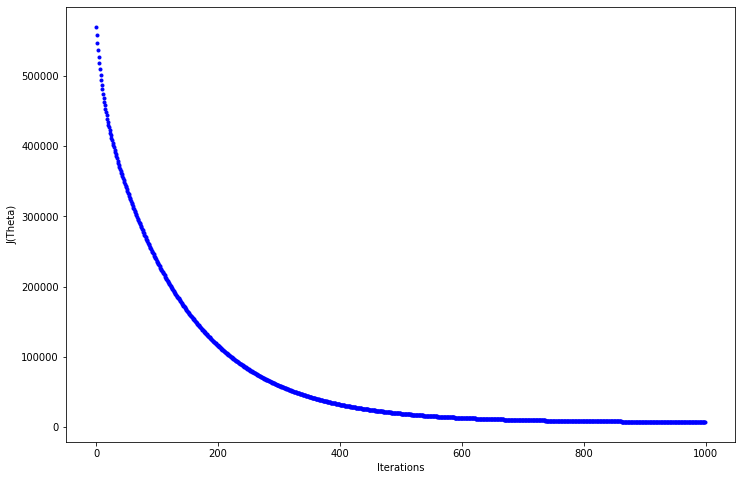

In [ ]:
# Inicialización de datos
x = np.random.uniform(low=0, high=2.0, size=(400,1))
y = getTargetCuadratic(x, False)

# Hiper-parámetros
lr = 0.01
n_iter = 1000

# Inicialización de los pesos de nuestro modelo
theta = np.random.randn(3, 1)
theta_size = 3

X_b = np.c_[np.ones((len(x),1)), x, x**2]
theta, cost_history, theta_history = gradient_descent(X_b, y, theta, lr, n_iter)

print('Theta0:\t{:0.3f},\nTheta1:\t{:0.3f}\nTheta2:\t{:0.3f}'.format(theta[0][0], theta[1][0], theta[2][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterations')
_ = ax.plot(range(n_iter), cost_history, 'b.')

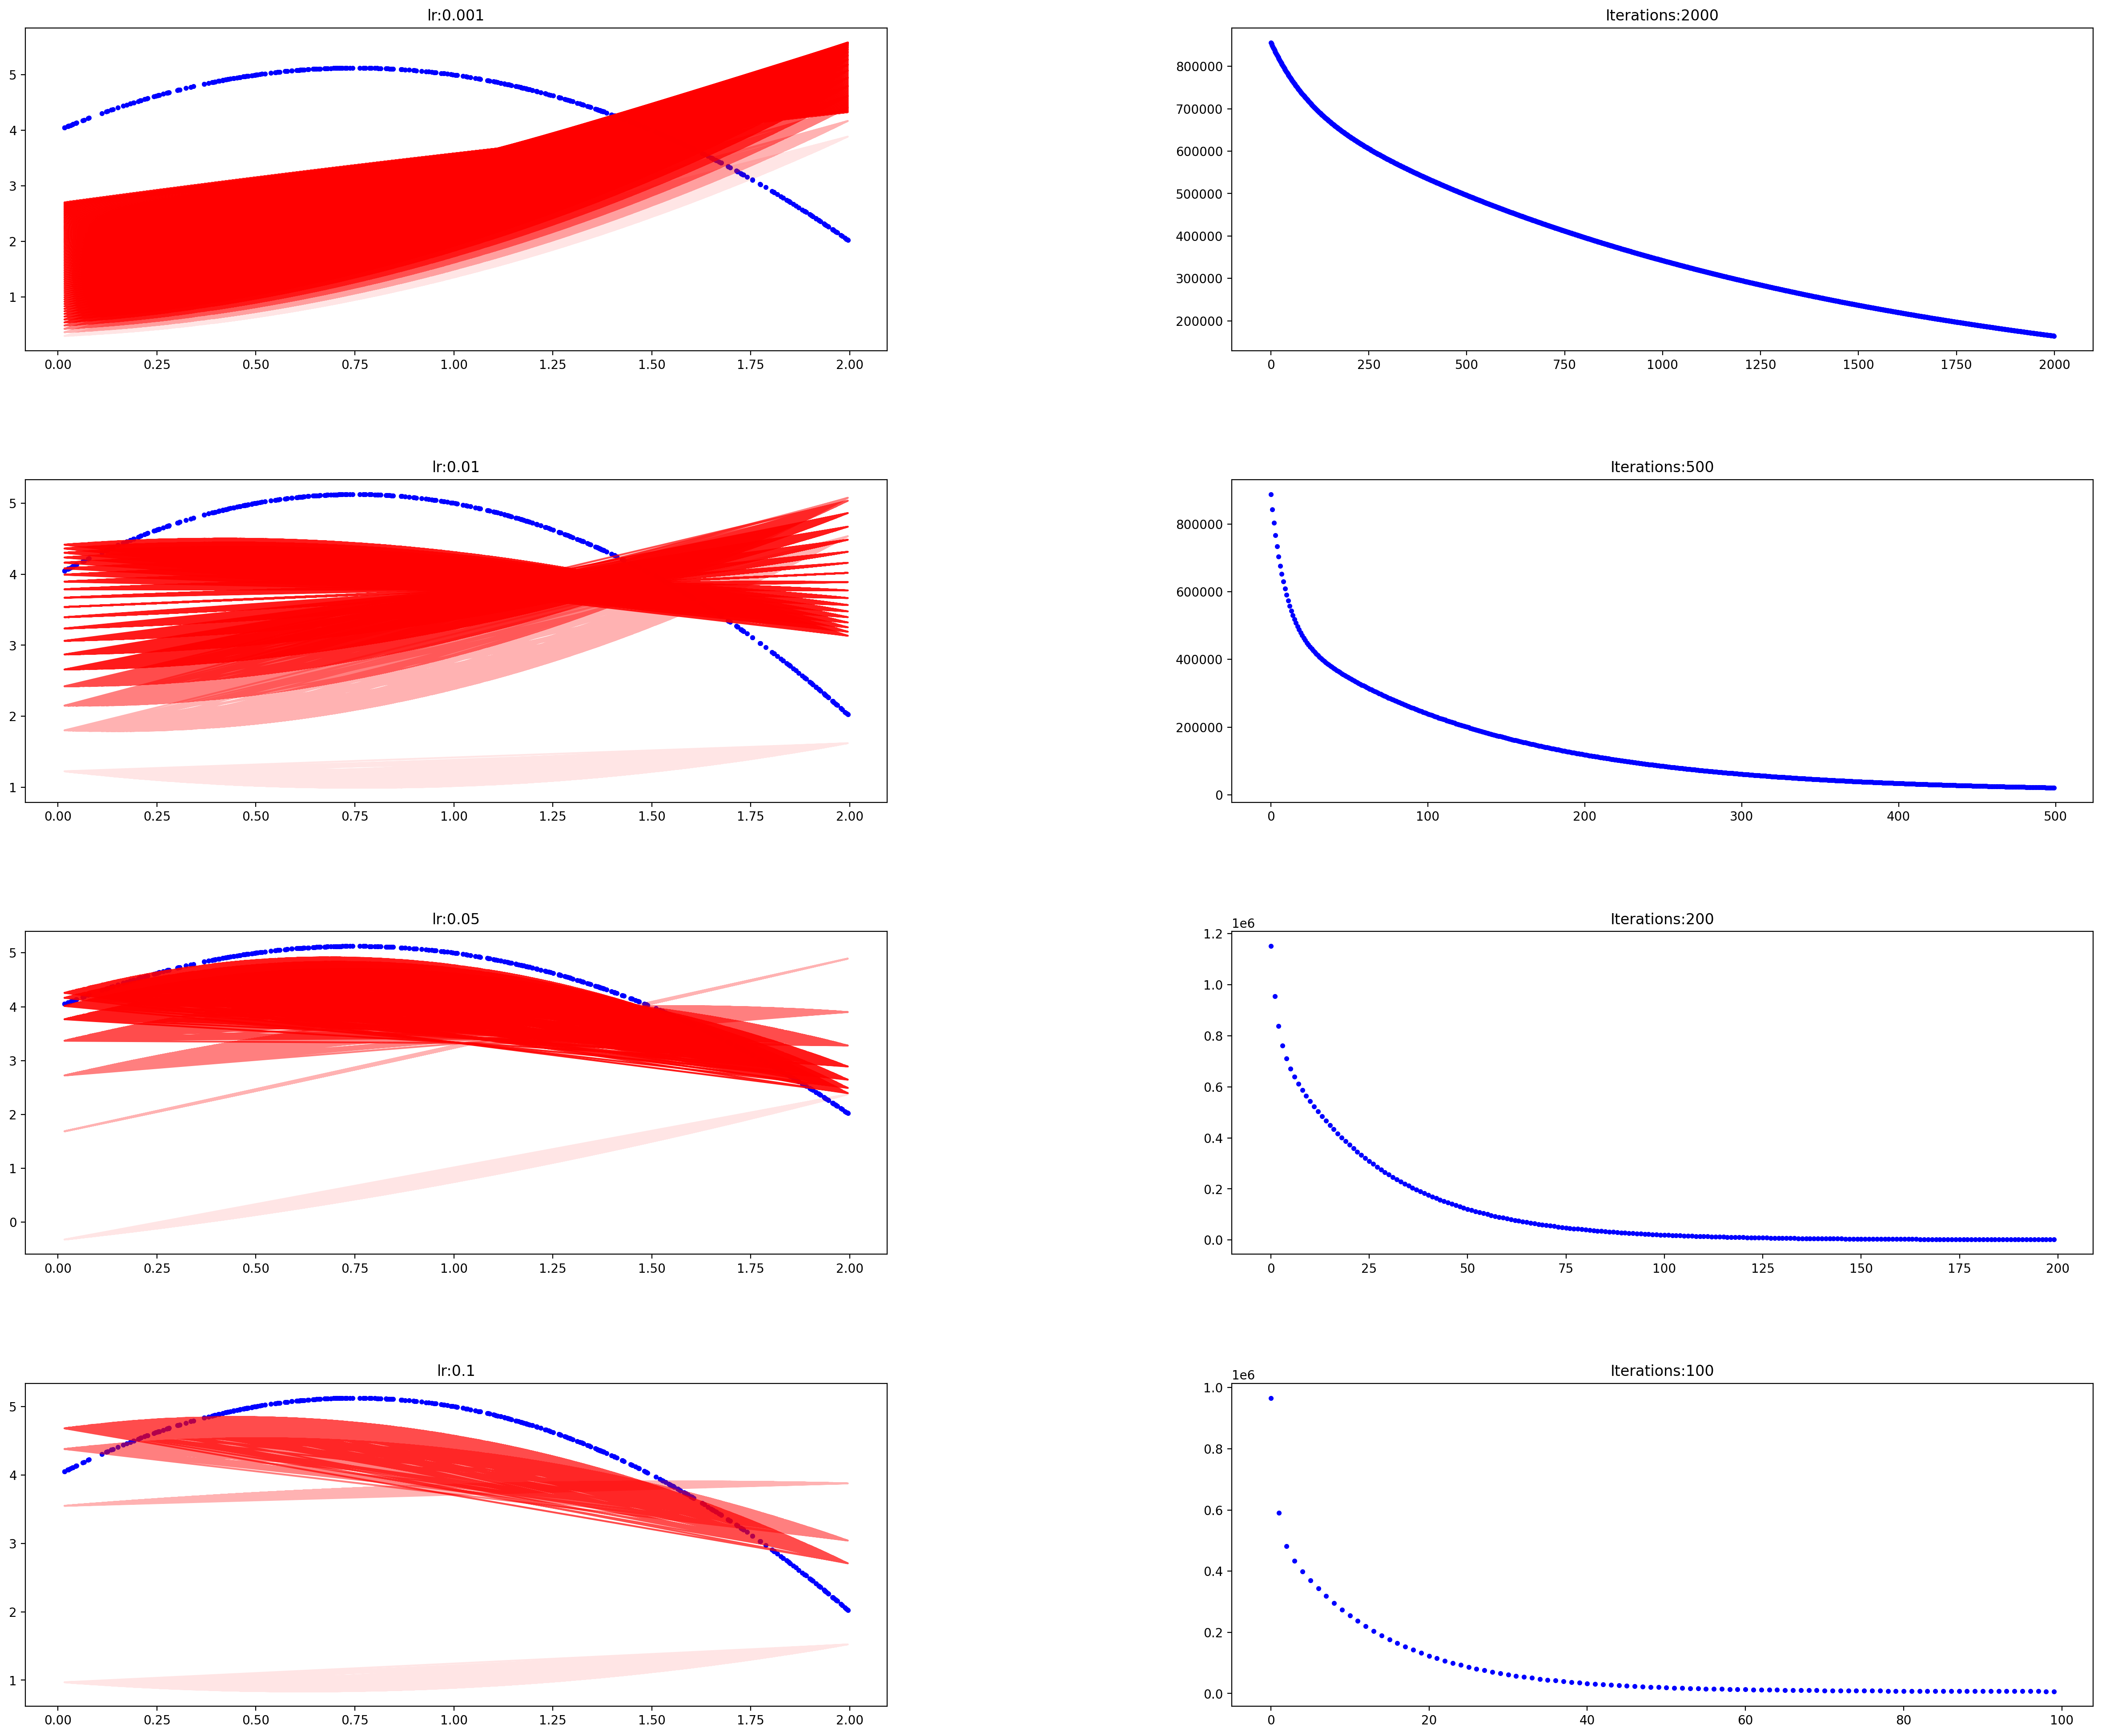

In [ ]:
fig = plt.figure(figsize=(30, 25), dpi=200)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

it_lr = [(2000, 0.001), (500, 0.01), (200, 0.05), (100, 0.1)]
count = 0
for n_iter, lr in it_lr:
    count += 1
    
    ax = fig.add_subplot(4, 2, count)
    count += 1
   
    ax1 = fig.add_subplot(4, 2, count)
    
    ax.set_title("lr:{}".format(lr))
    ax1.set_title("Iterations:{}".format(n_iter))
    plot_GD(x, y, theta_size, X_b, n_iter, lr, ax, ax1)

# Actividad 2 - Stochastic Gradient Descent
Ahora que entendemos como funciona un proceso básico de optimización basado en actualización del gradiente, podemos explorar problemas más complejos.

En esta actividad entrenaremos un modelo simple de aprendizaje profundo para predecir etiquetas de imágenes. En esta ocasión utilizaremos el dataset `CIFAR10`, que consiste en pequeñas imágenes de 10 clases diferentes.

Tal como vimos en clases, experimentamos con lo siguiente:

* Actualización de gradiente basada en `momentum` y `nesterov`.
* Alternativas a `SGD` como `Adagrad` y `Adam`.
* Learning Rate.
 
Para hacer el proceso más simple, utilizaremos `PyTorch`. Como ustedes ya deben saber, es un framework the python que nos permite trabajar con métodos de machine learning y que nos simplifica pasos como: la creación de modelos, obtención de dataset, cálculo del gradiente, etc.

### Datos
 
Lo maś importante para trabajar con estos modelos son los datos. Para esto, `PyTorch` tiene `torchvision.dataset` donde tiene una gran variedad de dataset y funciones que nos ayudan a trabajar con ellos.
 
En el siguiente código, bajamos nuestro dataset y creamos nuestro dataloaders.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

#Función que nos permite utilizar GPU durante el entrenamiento (si es que esta habilitada)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Veamos algunas imágenes de ejemplo 

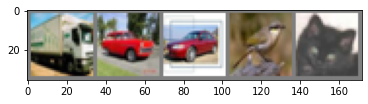

LABELS: 
truck   car   car  bird   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Las 10 etiquetas que utiliza este dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Obtenemos algunas imágenes de ejemplo 
loader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                     shuffle=True, num_workers=2)
dataiter = iter(loader)
images, labels = dataiter.next()

# Mostramos las imágenes 
imshow(torchvision.utils.make_grid(images))

# Imprimimos las etiquetas
print('LABELS: ')
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))



## Modelo

El modelo que vamos a utilizar es bastante pequeño. Contiene dos capas convolucionales y luego dos capas lineales, encargadas de hacer la clasificación.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # View es similar a flatten, se realiza un reshape de la forma (batch_size, dimension del vector)
        # 16 son la cantidad de canales del la capa convolucional de la capa anterior
        # 5 * 5 es el valor del alto por ancho del mapa de activación
        # Con este view, el vector x queda con dimension (batch_size, 16*5*5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)
epochs = 20

In [ ]:
import numpy as np

# Procedimiento de entrenamiento del modelo
def train(net, trainloader, optimizer, criterion, lr, epochs=60, scheduler=None):
    total_loss = []
    for epoch in range(epochs):  # loops sobre el dataset de entrenamiento multiples veces 

        running_loss = []
        for i, data in enumerate(trainloader, 0):

            # obtener los inputs en forma de lista de [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inicializa gradientes en zero
            optimizer.zero_grad()

            # forward + backward + optimizacion
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # guardar estadisticas 
            running_loss.append(loss.item())

        total_loss.append(np.mean(running_loss))
        if scheduler:
            scheduler.step(np.mean(running_loss))

    print('Finished Training of {}'.format(lr))
    return total_loss

#Procedimiento de prueba
#Similar al entrenamiento, la diferencia es que no se realiza actualización de los pesos
def test(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


## Actividad Practica 1

1.   Mire la documentación de PyTorch, específicamente la función SGD en https://pytorch.org/docs/stable/optim.html, y comente los diferentes parámetros que tiene la función. Aplique los conocimientos vistos en clases.

## Ajuste de los Hiper-Parámetros

Un punto importante para el entrenamiento correcto de modelos es la selección de hiper-parámetros. Tal como vimos en clases, existen varios algoritmos de optimización y cada uno de estos tiene diferentes hiper-parámetros que tenemos que ajustar.

Para ver el impacto que tiene utilizar diferentes hiper-parámetros vamos a utilizar al algoritmo SGD. Utilizando el mismo modelo con los mismos datos de entrenamiento y test, probaremos diferentes valores de:

* Learning Rate
* Momentum
* Nesterov

Probar con diferentes valores nos permite encontrar cual es el más indicado para realizar el entrenamiento completo posteriormente. Para probar se suele utilizar un subconjunto de los datos, cuando el set es muy grande, en nuestro caso no tenemos tantos por lo que no hay problema con hacer estas pruebas con todos los datos.

###   Learning Rate

Este valor determina qué tan grande o pequeños son los pasos que vamos a dar en dirección al gradiente. Un learning alto, significa que podemos dar pasos más grandes en dirección al óptimo, pero puede tener el problema de poca precisión. En cambio, un learning bajo, nos puede entregar la precisión para avanzar siempre hacia el óptimo pero puede demorarse mucho.



Finished Training of 0.0001
Accuracy of the network on the 10000 test images: 10 %
Finished Training of 0.001
Accuracy of the network on the 10000 test images: 40 %
Finished Training of 0.01
Accuracy of the network on the 10000 test images: 60 %
Finished Training of 0.1
Accuracy of the network on the 10000 test images: 59 %


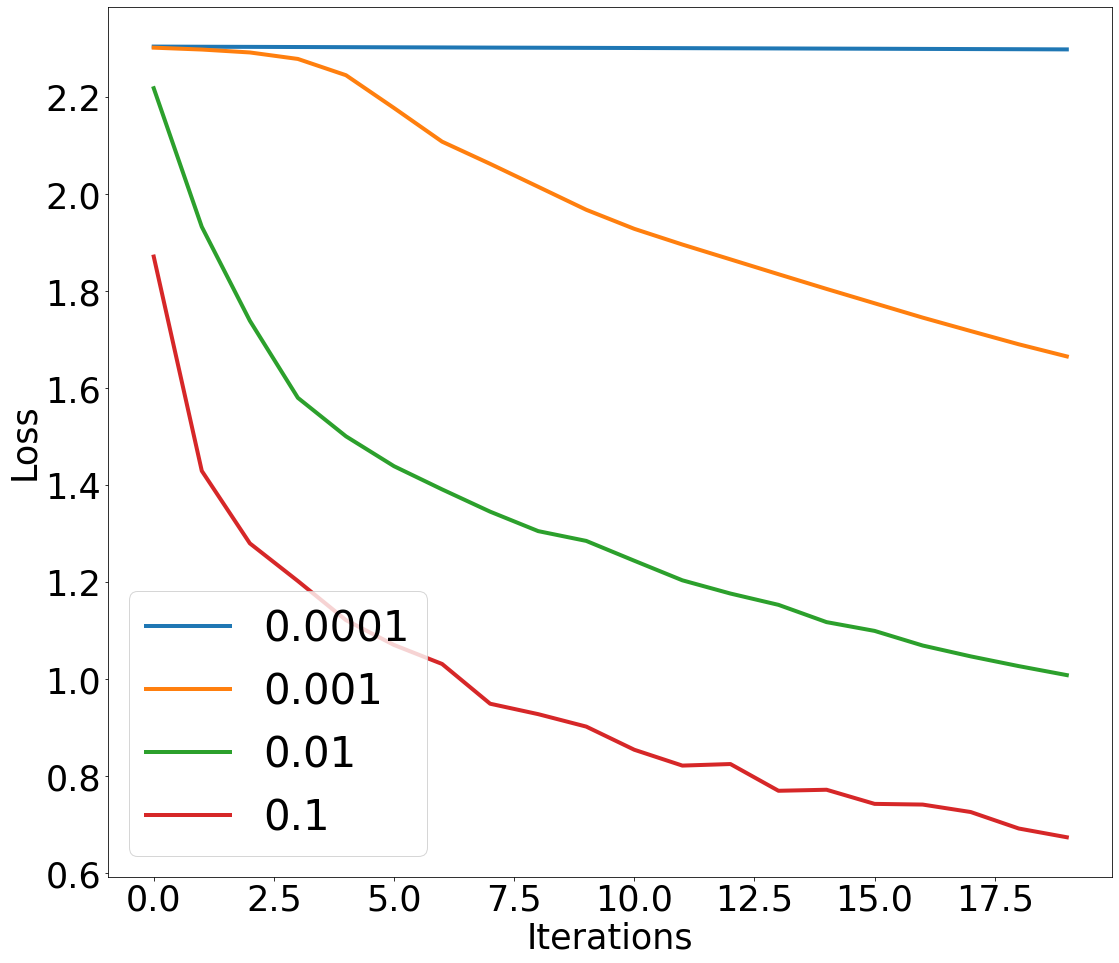

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(18, 16))
# Iteración sobre los diferentes valores de learning rate, manteniendo fijo el resto de los valores
for lr in [1e-4, 1e-3, 1e-2, 1e-1]:    
    net = Net().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    loss = train(net, trainloader, optimizer, criterion, lr, epochs=epochs)
    test(testloader, net)

    plt.plot(loss, label=lr, linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

### Actividad Práctica 2
 
 
1.  Explique el gráfico obtenido en el bloque anterior (con diferentes valores de learning rate). ¿Por qué hay tanta diferencia entre los diferentes valores de learning rate?
2.  En el siguiente bloque de código, entrene el modelo con valores mayores de learning rate (1, 10, 100).
3.  Comente los resultados, explicando la diferencia de ambos gráficos (el anterior y el generado por uds.).



In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(18, 16))

"""
    Your Code Here
"""

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

###   Momentum

El momentum nos indica la velocidad con la que nos seguimos moviendo en una dirección en la que nos habíamos estado moviendo, independiente de la dirección en la que nos indica el gradiente en este momento.

El momentum es una forma de suavizar el movimiento para que la historia del gradiente tenga un peso asociado y no solamente el gradiente del batch actual.
 
En el siguiente bloque analizaremos diferentes valores de $\rho$, manteniendo fijo el *learning rate*.


Finished Training of 0.0
Accuracy of the network on the 10000 test images: 57 %
Finished Training of 0.3
Accuracy of the network on the 10000 test images: 60 %
Finished Training of 0.6
Accuracy of the network on the 10000 test images: 62 %
Finished Training of 0.9
Accuracy of the network on the 10000 test images: 60 %


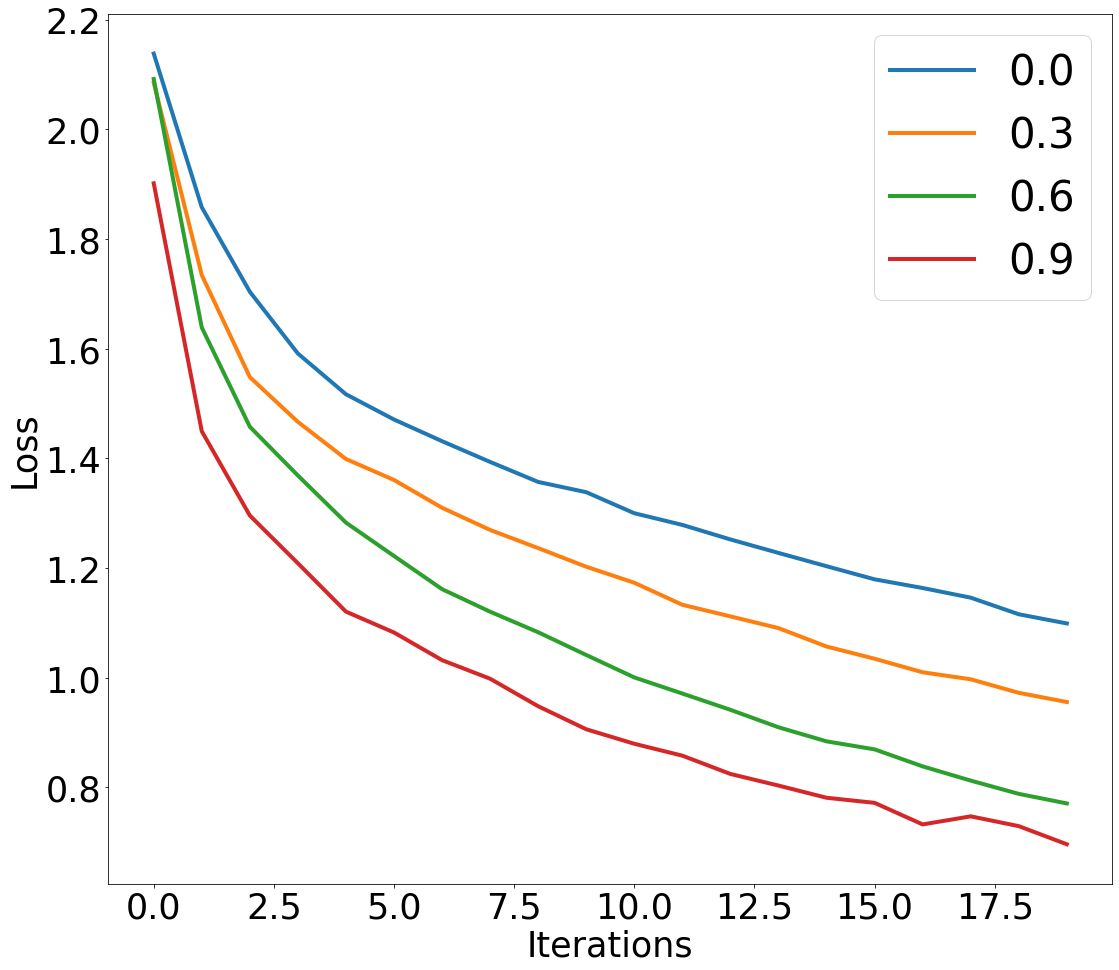

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(18, 16))
for momentum in [0.0, 0.3, 0.6, 0.9]:   
    net = Net().to(device) 
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=momentum)
    loss = train(net, trainloader, optimizer, criterion, momentum, epochs=epochs)
    test(testloader, net)

    plt.plot(loss, label=momentum, linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

###   Nesterov
 
Por último, verificamos cómo contribuye el utilizar el momentum de Nesterov. Recordar que la idea detrás de este es aplicar el momentum antes de hacer la actualización de los pesos, lo que lo convierte en una visión a futuro de la velocidad.
 
Para este parámetro, tenemos solo dos opciones de valores, aplicar o no aplicar Nesterov. Pero lo podemos aplicar con diferentes valores de momentum.
 
Idealmente debemos hacer una matriz de combinaciones posibles, es decir, con cada valor de *learning rate* probar con diferentes valores de momentum. Pero también esto es lo que más tiempo consume, por lo que siempre existe un trade-off entre la cantidad de veces que uno puede correr el modelo y la cantidad de hiper-parámetros que uno puede probar.



Finished Training of True
Accuracy of the network on the 10000 test images: 59 %
Finished Training of False
Accuracy of the network on the 10000 test images: 60 %


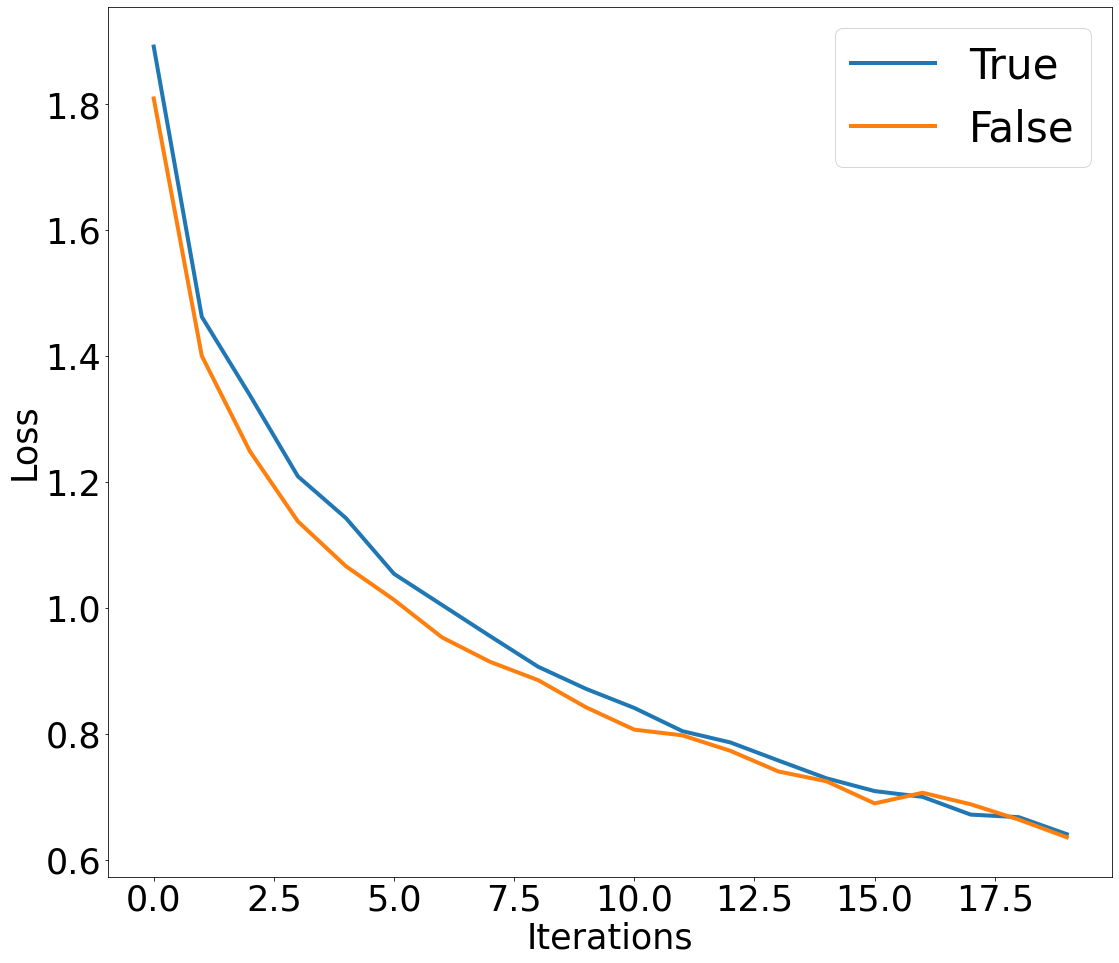

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(18, 16))
for nest in [True, False]:    
    net = Net().to(device)
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, nesterov=nest)
    loss = train(net, trainloader, optimizer, criterion, nest, epochs=epochs)
    test(testloader, net)

    plt.plot(loss, label=nest, linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

#Actividad 3 - Métodos de gradiente adaptativos
 
En clases vimos alternativas al algoritmo de `SGD` que presentaba ciertas mejoras, como un learning rate propio para cada parámetro y/o una normalización en base a los momentos estadísticos de las historias de los gradientes.
 
A continuación compararemos `SGD` con `AdaGrad` y `Adam`. Por el momento solo utilizaremos un solo valor de *learning rate* para cada uno, pero idealmente se tendría que comparar con más de uno.
 
Cuál funciona mejor puede depender mucho del problema (datos y modelo), por lo que si se quiere lograr el mejor resultado posible lo ideal es probar con varias combinaciones posibles.
 
En la práctica, correr el modelo completo puede ser muy costoso, por lo que se suele escoger `Adam` como optimizador y con este se prueban diferentes valores dependiendo un subgrupo de datos.
 

**Tip:** Dado que `Adam` actualiza los diferentes *learning rate* de los parámetros en cada paso, se suele partir con un valor más bajo para el *learning rate* inicial que puede ser 1e-3 or 5e-4. De todas formas siempre dependerá más del problema, por lo que es mejor probar.

Finished Training of <class 'torch.optim.sgd.SGD'>
Accuracy of the network on the 10000 test images: 58 %
Finished Training of <class 'torch.optim.adam.Adam'>
Accuracy of the network on the 10000 test images: 59 %
Finished Training of <class 'torch.optim.adagrad.Adagrad'>
Accuracy of the network on the 10000 test images: 50 %


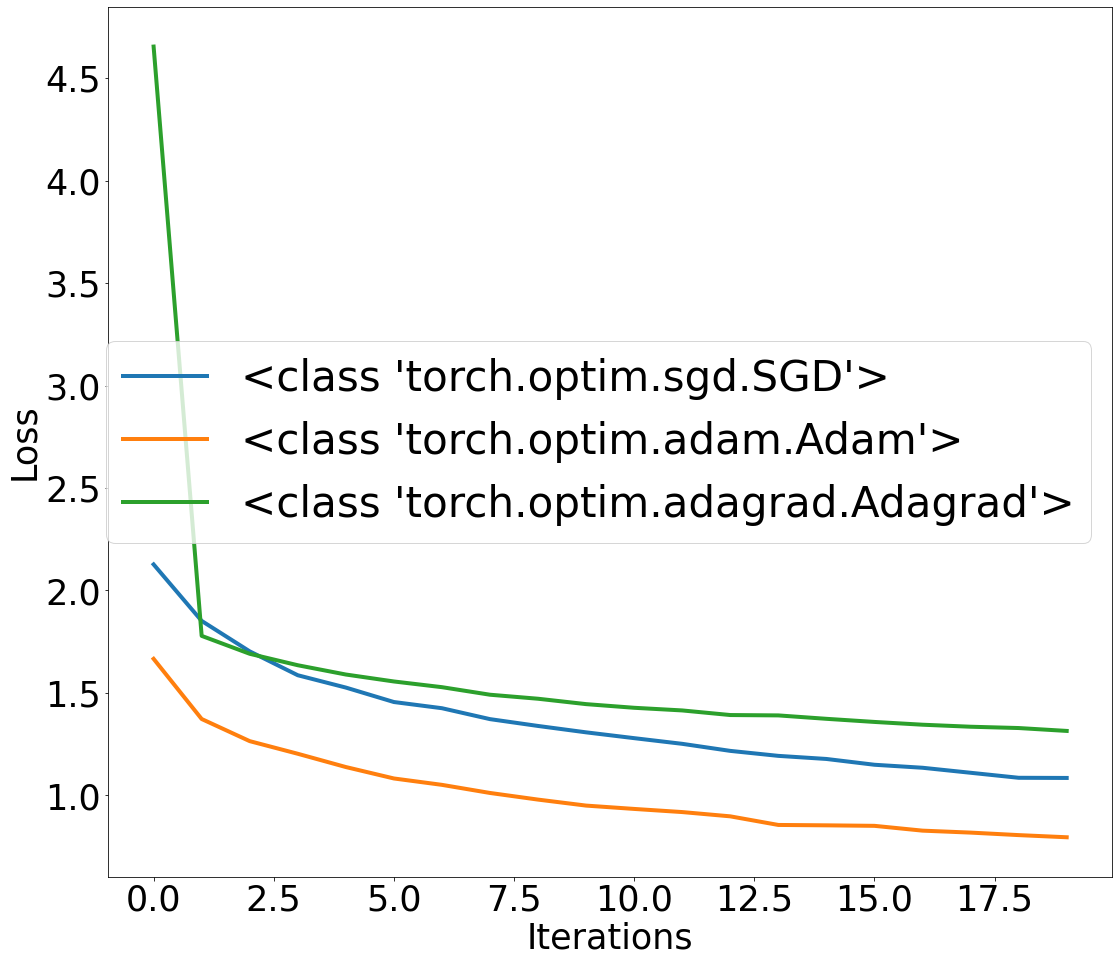

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(18, 16))
for opt in [(1e-1, optim.SGD), (1e-2, optim.Adam), (1e-1, optim.Adagrad)]:    
    net = Net().to(device)
    optimizer = opt[1](net.parameters(), lr=opt[0])
    loss = train(net, trainloader, optimizer, criterion, opt[1], epochs=epochs)
    test(testloader, net)

    plt.plot(loss, label=opt[1], linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

## Actividad Práctica 3
 
 
1.  Encuentre un mejor valor de learning rate para el algoritmo `Adam`, si lo cree necesario, puede cambiar los valores de betas. (https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)
2.  Comente los resultados y dé una pequeña explicación de por qué la diferencia con respecto a SGD.


In [ ]:
""" Your code here """

# Actividad 4 - Ajuste del Learning Rate durante entrenamiento
 
Una forma de acelerar el proceso de entrenamiento es ir adaptando el learning rate durante este proceso. Esto quiere decir, ir disminuyendo el valor inicial cuando se cumplan ciertos requisitos, ya que al principio podemos movernos más rápido en dirección del gradiente y a medida que nos acercamos al óptimo necesitamos más precisión. Estos requisitos pueden ser varios, pero los más utilizados son
 
1. Cantidad de Épocas
2. Valor de la función de pérdida
 
El primer criterio consiste en disminuir el learning rate por un factor $f$ cada cierta cantidad de épocas. Este valor depende mucho del problema y para eso es bueno ir revisando cómo evoluciona el valor de la función de pérdida durante el entrenamiento.
 
El segundo criterio considera un estancamiento en el valor de la función de pérdida. Esto quiere decir que el valor de la función no está disminuyendo con el actual valor. Lo que se suele hacer es esperar una cantidad de épocas determinada, si no baja el valor (mayor a un umbral) el *learning rate* se multiplica por un factor.

## Cantidad de épocas

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished Training of <class 'torch.optim.sgd.SGD'>
Accuracy of the network on the 10000 test images: 58 %
Finished Training of <class 'torch.optim.adam.Adam'>
Accuracy of the network on the 10000 test images: 59 %
Finished Training of <class 'torch.optim.adagrad.Adagrad'>
Accuracy of the network on the 10000 test images: 50 %


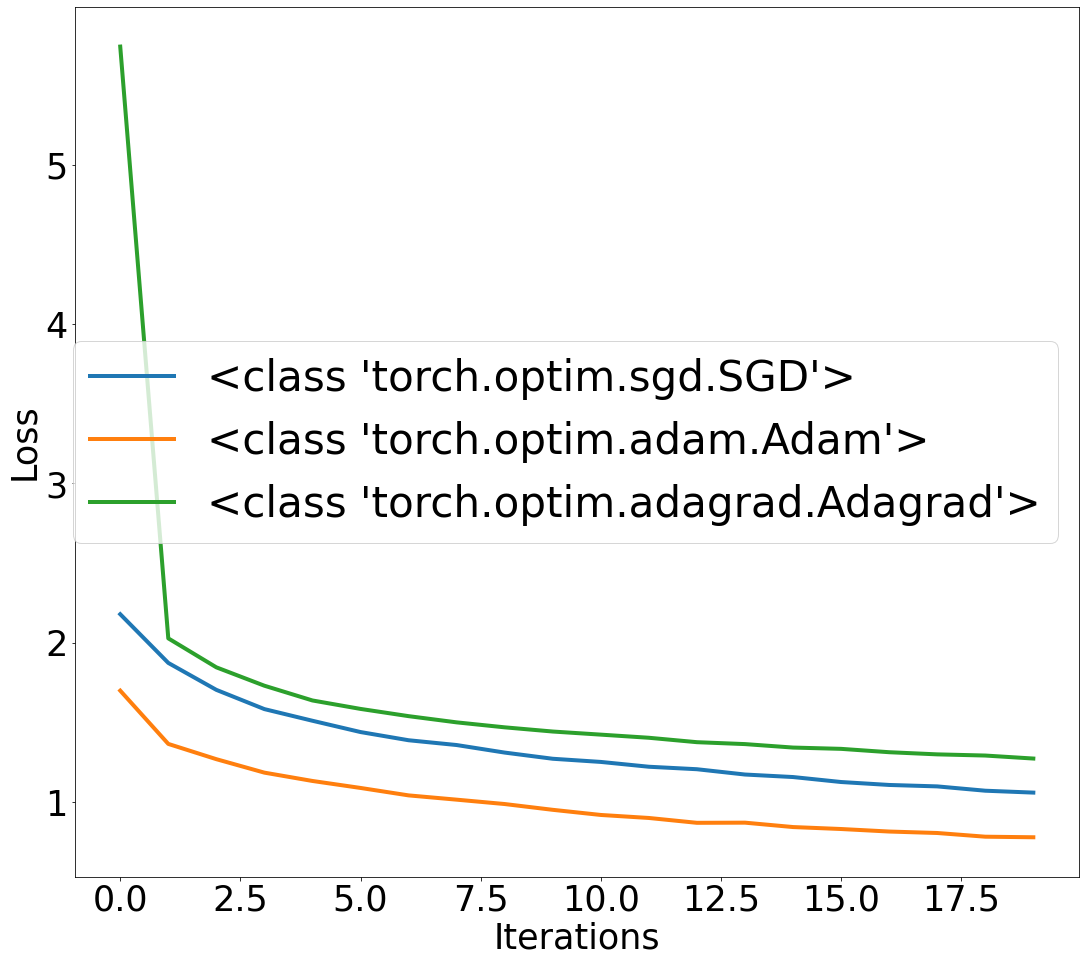

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
fig = plt.figure(figsize=(18, 16))
for opt in [(1e-1, optim.SGD), (1e-2, optim.Adam), (1e-1, optim.Adagrad)]:    
    net = Net().to(device)
    optimizer = opt[1](net.parameters(), lr=opt[0])
    scheduler = optim.lr_scheduler.StepLR(optimizer, 10)
    loss = train(net, trainloader, optimizer, criterion, opt[1], epochs=epochs, scheduler=scheduler)
    test(testloader, net)

    plt.plot(loss, label=opt[1], linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()

## Valor función de pérdida

Finished Training of <class 'torch.optim.sgd.SGD'>
Accuracy of the network on the 10000 test images: 57 %
Finished Training of <class 'torch.optim.adam.Adam'>
Accuracy of the network on the 10000 test images: 59 %
Finished Training of <class 'torch.optim.adagrad.Adagrad'>
Accuracy of the network on the 10000 test images: 54 %


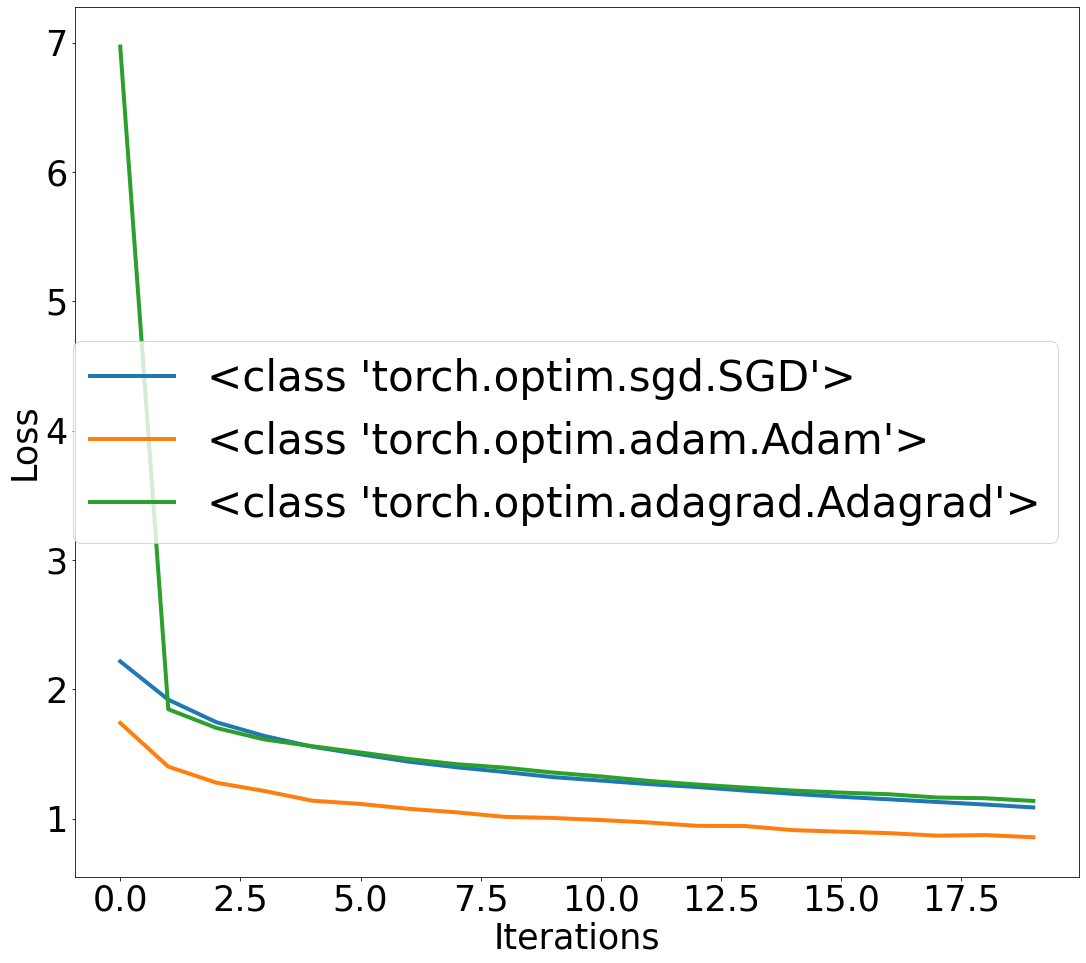

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
fig = plt.figure(figsize=(18, 16))
for opt in [(1e-1, optim.SGD), (1e-2, optim.Adam), (1e-1, optim.Adagrad)]:    
    net = Net().to(device)
    optimizer = opt[1](net.parameters(), lr=opt[0])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    loss = train(net, trainloader, optimizer, criterion, opt[1], epochs=epochs, scheduler=scheduler)
    test(testloader, net)

    plt.plot(loss, label=opt[1], linewidth=4)

plt.xlabel("Iterations", fontsize=35)
plt.xticks(fontsize=35)
plt.ylabel("Loss", fontsize=35)
plt.yticks(fontsize=35)
plt.legend(prop={'size': 42})
plt.show()